In [1]:
import numpy as np
import torch
import os
import sys
import random
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader

module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path+"/models")
sys.path.append(module_path+"/train")
sys.path.append(module_path+"/datasets")

from factor_vae import FactorVAEDSprites, Discriminator
from datasets import train_test_random_split, load_dsprites, CustomDataset
from train import train_factor_vae, test_factor_vae

In [2]:
dataset = load_dsprites("../datasets/dsprites.npz",False)
imgs = dataset["imgs"]

In [3]:
data_size = 1000
data = CustomDataset(imgs,data_size)

In [4]:
data_train, data_test = train_test_random_split(data, 0.8)

In [5]:
batch_size = 64
train_loader = DataLoader(data_train, batch_size=batch_size,shuffle=True)
test_loader = DataLoader(data_test, batch_size=batch_size,shuffle=False)

In [6]:
model = FactorVAEDSprites()
discriminator = Discriminator(nb_layers=4,hidden_dim=500)
vae_optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-4)
gamma = 0
epochs = 10

In [7]:
train_factor_vae(model, discriminator, epochs, train_loader, vae_optimizer, discriminator_optimizer, gamma, 'bernoulli')

/Users/ireneburger/opt/anaconda3/envs/practical-atiml/lib/python3.8/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch 0 finished, loss: 2609.0653545673076, recon loss: 2609.0296912560098, kl div: 0.03564063846044099
Epoch 1 finished, loss: 1170.0019014798677, recon loss: 1168.4371948242188, kl div: 1.5647093814152937
Epoch 2 finished, loss: 648.0207895132212, recon loss: 640.5843599759615, kl div: 7.436437423412617
Epoch 3 finished, loss: 600.8275709885818, recon loss: 590.93896484375, kl div: 9.888604677640474
Epoch 4 finished, loss: 586.8980665940505, recon loss: 579.1110417292668, kl div: 7.787020389850323
Epoch 5 finished, loss: 581.2864896334135, recon loss: 575.8247586763822, kl div: 5.461729343120869
Epoch 6 finished, loss: 578.5827448918269, recon loss: 574.6254272460938, kl div: 3.9573171138763428
Epoch 7 finished, loss: 572.6511160043569, recon loss: 569.7009699894832, kl div: 2.9501425119546743
Epoch 8 finished, loss: 574.275620680589, recon loss: 571.8841975285457, kl div: 2.391420914576604
Epoch 9 finished, loss: 575.3922964242788, recon loss: 573.407700758714, kl div: 1.98459999377

([2609.0653545673076,
  1170.0019014798677,
  648.0207895132212,
  600.8275709885818,
  586.8980665940505,
  581.2864896334135,
  578.5827448918269,
  572.6511160043569,
  574.275620680589,
  575.3922964242788],
 [2609.0296912560098,
  1168.4371948242188,
  640.5843599759615,
  590.93896484375,
  579.1110417292668,
  575.8247586763822,
  574.6254272460938,
  569.7009699894832,
  571.8841975285457,
  573.407700758714],
 [0.03564063846044099,
  1.5647093814152937,
  7.436437423412617,
  9.888604677640474,
  7.787020389850323,
  5.461729343120869,
  3.9573171138763428,
  2.9501425119546743,
  2.391420914576604,
  1.984599993779109],
 [-0.001337439466554385,
  -0.08127825477948555,
  0.1234084668640907,
  0.47893123443310076,
  0.8138050849621112,
  0.9480095414014963,
  0.939085841178894,
  0.6303138331725047,
  0.6113247894323789,
  0.5915656364881076],
 [0.6927721775495089,
  0.6865348678368789,
  0.6014246023618258,
  0.47323854152972883,
  0.38087987212034374,
  0.3611410626998314,
  

In [8]:
test_factor_vae(model, discriminator, test_loader, gamma, 'bernoulli')

Test loss: 575.2989807128906


torch.Size([64, 64])
torch.Size([1, 64, 64])


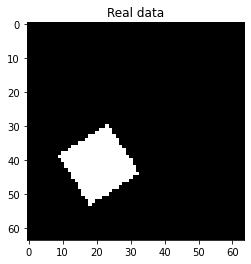

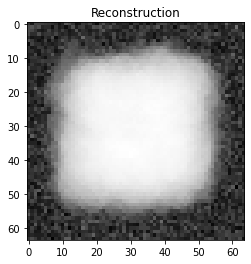

torch.Size([64, 64])
torch.Size([1, 64, 64])


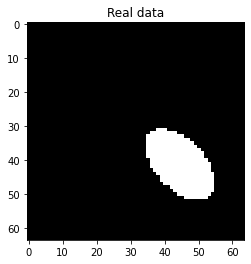

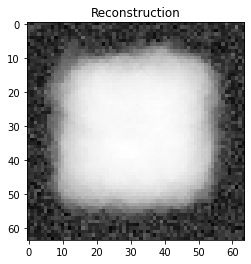

torch.Size([64, 64])
torch.Size([1, 64, 64])


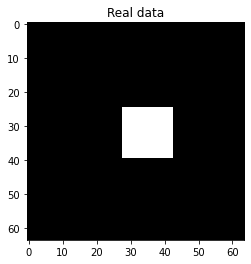

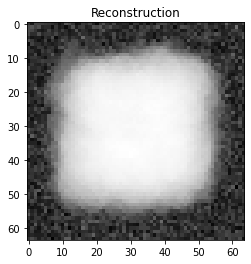

In [12]:
with torch.no_grad():
    for i in [1,15,20]:
        data, _ = data_test[i]
        data = data.float()
        recon, mu, logvar, z = model(data)
        plt.imshow(data, cmap='Greys_r')
        plt.title("Real data")
        plt.show()
        plt.imshow(recon.squeeze(), cmap='Greys_r')
        plt.title("Reconstruction")
        plt.show()

In [13]:
dataset.allow_pickle = True
latents_sizes = dataset['metadata'][()][b'latents_sizes']
latents_bases = np.concatenate((latents_sizes[::-1].cumprod()[::-1][1:],
                                np.array([1,])))

def latent_to_index(latents):
    return np.dot(latents, latents_bases).astype(int)

def sample_latent(size=1, fixed = None):
    samples = np.zeros((size, latents_sizes.size))
    for lat_i, lat_size in enumerate(latents_sizes):
        if fixed == lat_i:
            fixed_value = np.random.randint(lat_size, size=1)
            samples[:, lat_i] = np.full(size, fixed_value)
        else:
            samples[:, lat_i] = np.random.randint(lat_size, size=size)
    return samples

In [14]:
def compute_latent_variance(size):
    sample = sample_latent(size)
    imgs_sampled = imgs[latent_to_index(sample)]
    latents = np.zeros((size,10))
    for i,data in enumerate(imgs_sampled):
        data = torch.from_numpy(data).unsqueeze(0).float().unsqueeze(0)
        recon, mu, logvar, z = model(data)
        z = np.array(z.squeeze().detach().numpy())
        latents[i] = z
    global_vars = np.var(latents, axis = 0) 
    return global_vars

latents_global_variance = compute_latent_variance(1000)


In [15]:
def FactorVAE_entanglement_metric(nb_samples,sample_size):
    loss = 0
    classification = np.zeros((len(latents_sizes),10))
    for i in range(nb_samples):
        k = np.random.randint(len(latents_sizes)-1)+1
        latents_sampled = sample_latent(size=sample_size, fixed=k)
        indices_sampled = latent_to_index(latents_sampled)
        imgs_sampled = imgs[indices_sampled]
        latents_rep = np.zeros((sample_size,10))
        for data in imgs_sampled:
            data = torch.from_numpy(data).unsqueeze(0).float().unsqueeze(0)
            recon, mu, logvar, z = model(data)
            z = np.array(z.squeeze().detach().numpy())
            latents_rep[i] = z
        latents_var = np.var(latents_rep, axis = 0) 
        latents_var_normalized = np.divide(latents_var, latents_global_variance)
        idx = np.argmin(latents_var_normalized)
        classification[k,idx]+=1
    print(classification)
    for i in range(len(latents_sizes)):
        loss = loss + np.sum(classification[i])- np.max(classification[i])
    return loss/nb_samples

In [16]:
FactorVAE_entanglement_metric(50,500)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 5. 1. 0. 0. 1. 0. 1. 0.]
 [2. 0. 6. 2. 0. 0. 1. 0. 1. 0.]
 [2. 2. 3. 1. 1. 1. 1. 0. 0. 0.]
 [5. 0. 1. 0. 0. 0. 0. 1. 0. 1.]
 [3. 1. 2. 0. 0. 0. 0. 0. 2. 1.]]


0.56